# Linear regression

This tutorial provides a basic example of several calibration procedures using a linear regression model.

# Google Colab setup (optional)

When running this notebook in Google Colab, execute the following first (also ensure that you restart the Google Colab session after the setup):

In [ ]:
! pip install poetry
! poetry config virtualenvs.create false
! poetry self update 1.8.5
! rm -f pyproject.toml
! wget https://raw.githubusercontent.com/Plant-Food-Research-Open/calisim-examples-workshop-material/refs/heads/main/pyproject.toml
! poetry install --no-root
! rm -rf calisim-examples-workshop-material
! git clone --depth 1 https://github.com/Plant-Food-Research-Open/calisim-examples-workshop-material.git
! mv calisim-examples-workshop-material/workshop/jfruit2/* .

# Imports

We will first import all required dependencies.

In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.statistics import MeanSquaredError, L2Norm

# Observed data

We will next generate the 100 observations with 5 parameters.

In [29]:
p = 5
n = 100

rng = np.random.default_rng(100)
X = rng.standard_normal(size=(n, p))

def g(beta):
    return X @ beta

beta_true = np.linspace(-1, 1, num=p)
observation_noise = rng.standard_normal(size=n)
y = g(beta_true) + observation_noise

observed_df = pd.DataFrame(X, columns = [f"x_{i}" for i in range(p)])
observed_df["y"] = y
observed_df

,x_0,x_1,x_2,x_3,x_4,y
0,-1.157550,0.289756,0.780854,0.543974,-0.961383,2.285896
1,1.071009,0.701456,0.704973,0.745063,1.104347,0.669554
2,2.242972,-0.611493,0.047211,1.754235,-1.337980,-1.459401
3,0.325574,-0.689118,-0.019822,0.474753,-1.931101,-2.094742
4,-0.992478,-1.405471,-0.231096,-0.688847,1.515106,1.770539
...,...,...,...,...,...,...
95,-1.197676,0.862309,-0.881934,1.284170,-2.485180,-2.335480
96,-0.508350,0.826742,0.845005,-1.971125,0.178238,-0.189965
97,0.159850,0.249380,-0.404957,-0.818494,0.162018,1.357254
98,0.537970,0.959307,-0.115592,-0.862106,0.699542,-2.153486


<Axes: xlabel='x_0', ylabel='y'>

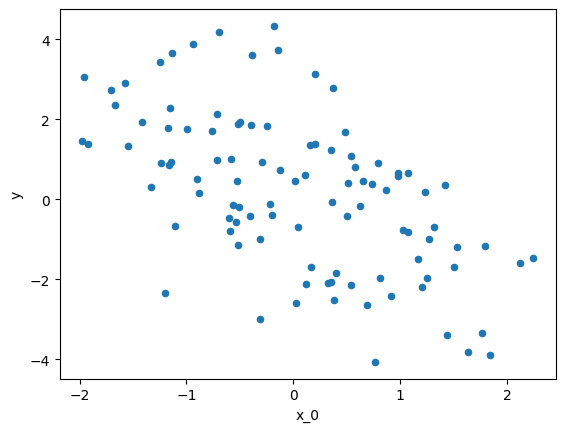

In [30]:
observed_df.plot.scatter("x_0", "y")

We aim to recover the ground truth parameters using several calibration procedures.

In [31]:
pd.DataFrame({
    "beta_name": [f"x_{i}" for i in range(p)],
    "beta_value": beta_true
})

,beta_name,beta_value
0,x_0,-1.0
1,x_1,-0.5
2,x_2,0.0
3,x_3,0.5
4,x_4,1.0


# Gradient-based optimisation using least squares

For linear regression, we can typically easily fit a model using a least squares algorithm and a gradient-based optimiser. Let's start there.

In [32]:
import numpy as np
from scipy.optimize import least_squares

def residuals(beta, X, y):
    return X @ beta - y

beta_0 = np.zeros(X.shape[1])
opt_results = least_squares(residuals, beta_0, args=(X, y))

pd.DataFrame({
    "beta_name": [f"x_{i}" for i in range(p)],
    "beta_estimate": opt_results.x,
    "beta_value": beta_true
})

,beta_name,beta_estimate,beta_value
0,x_0,-0.985116,-1.0
1,x_1,-0.505724,-0.5
2,x_2,0.145507,0.0
3,x_3,0.611258,0.5
4,x_4,1.048820,1.0


<Axes: xlabel='observed', ylabel='simulated'>

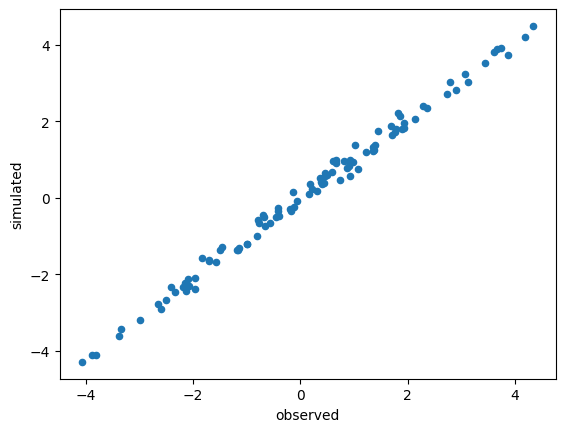

In [33]:
pd.DataFrame({
    "observed": observed_df.y.values,
    "simulated": g(opt_results.x) + observation_noise
}).plot.scatter("observed", "simulated")

However, suppose that you are working with a more complex scientific computer simulation model. We may not have access to the gradients of the model or perhaps the model is a black-box. Moreover, we might be working with a stochastic simulation model that is highly noisy, such as an agent-based model. Furthermore, it may take several hours or days to run the forward model just once, hence the need for parallelisation and/or surrogate modelling.

In these cases, more sophisticated calibration procedures are required such as those offered by calisim. Let's apply a sensitivity analysis, black-box optimisation, and Bayesian calibration via calisim.

# Sensitivity analysis

We will start with a Sobol sensitivity analysis to identity and quantify how the variation in the 5 input parameters of the model influences the variation in the model outputs. 

In [34]:
from calisim.sensitivity import (
	SensitivityAnalysisMethod,
	SensitivityAnalysisMethodModel,
)

We first construct the parameter specification for the Sobol sensitivity analysis. This defines the parameter ranges, distribution types, and data types.

In [35]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="x_0",
			distribution_name="uniform",
			distribution_args=[-1, 1],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_1",
			distribution_name="uniform",
			distribution_args=[-1, 1],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_2",
			distribution_name="uniform",
			distribution_args=[-1, 1],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_3",
			distribution_name="uniform",
			distribution_args=[-1, 1],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_4",
			distribution_name="uniform",
			distribution_args=[-1, 1],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

/home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/SALib/util/problem.py:213: UserWarning:

Parallel evaluation is an experimental feature and may not work.

/home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



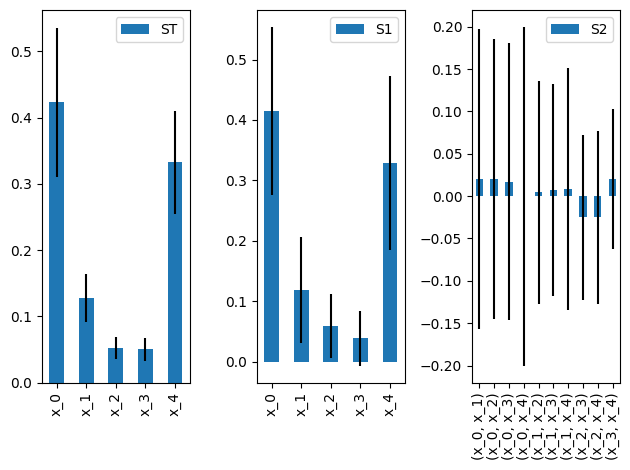

/home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



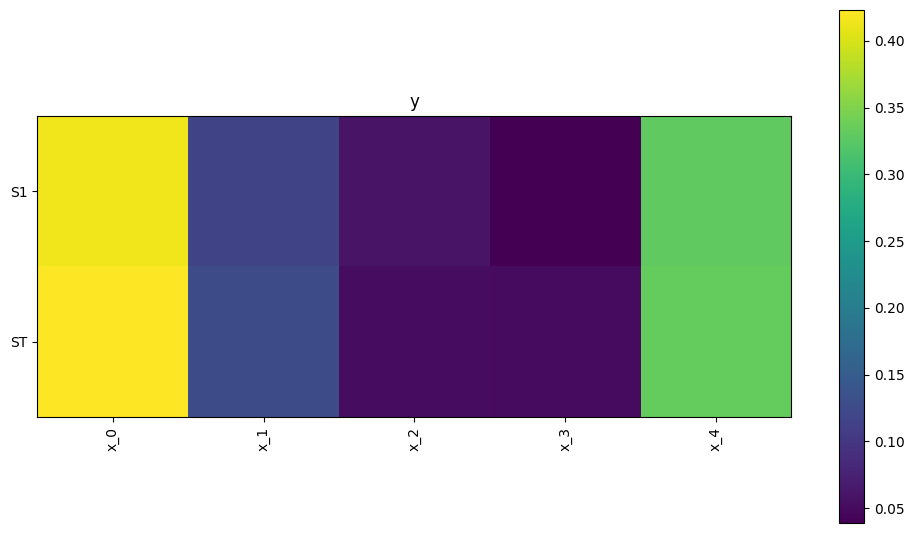

In [36]:
def sensitivity_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    beta_star = np.array(list(parameters.values()))
    simulated_data = g(beta_star) + observation_noise

    metric = MeanSquaredError()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

specification = SensitivityAnalysisMethodModel(
	experiment_name="salib_sensitivity_analysis",
	parameter_spec=parameter_spec,
	observed_data=observed_df.y.values,
	method="sobol",
	n_samples=128,
    n_jobs=8,
	output_labels=["y"],
	verbose=True,
	batched=False,
	method_kwargs=dict(calc_second_order=True, scramble=True),
	analyze_kwargs=dict(
		calc_second_order=True,
		num_resamples=200,
		conf_level=0.95,
	),
)

calibrator = SensitivityAnalysisMethod(
	calibration_func=sensitivity_func, specification=specification, engine="salib"
)

calibrator.specify().execute().analyze()

We see that our model is most sensitive to variation in x_0 and x_4. It is least sensitive to x_2

# Optimisation

We will next perform black-box optimisation to estimate the parameter values that lead to the smallest mean square error between observed and simulated data. 

In [37]:
from calisim.optimisation import OptimisationMethod, OptimisationMethodModel

We will reuse the parameter specification from the Sobol sensitivity analysis. One objective of calisim is to faciliate a modular design that allows users to mix-and-match different calibration procedures.

[I 2025-10-02 12:15:28,882] A new study created in memory with name: optuna_optimisation
[I 2025-10-02 12:15:28,892] Trial 0 finished with value: 6.824707018732518 and parameters: {'x_0': 0.9222283687186166, 'x_1': 0.664349814136783, 'x_2': 0.7936163468784221, 'x_3': 0.41604757423253425, 'x_4': -0.26932954625525185}. Best is trial 0 with value: 6.824707018732518.
[I 2025-10-02 12:15:28,899] Trial 1 finished with value: 5.256008114935769 and parameters: {'x_0': 0.6788056192361225, 'x_1': 0.2613086463178953, 'x_2': 0.12259933839842718, 'x_3': 0.017558251889844723, 'x_4': -0.27441793394410174}. Best is trial 1 with value: 5.256008114935769.
[I 2025-10-02 12:15:28,906] Trial 2 finished with value: 2.203570902994775 and parameters: {'x_0': 0.1445879607596643, 'x_1': -0.3736067434828819, 'x_2': -0.3530712613439011, 'x_3': 0.06871282518963207, 'x_4': 0.39182303274238595}. Best is trial 2 with value: 2.203570902994775.
[I 2025-10-02 12:15:28,909] Trial 3 finished with value: 3.0642780084108368

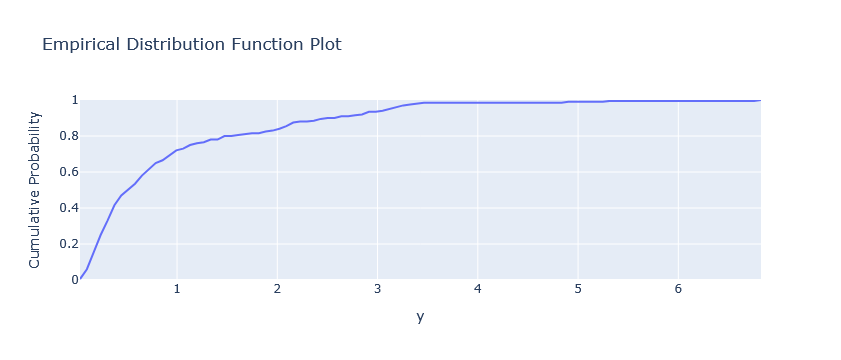

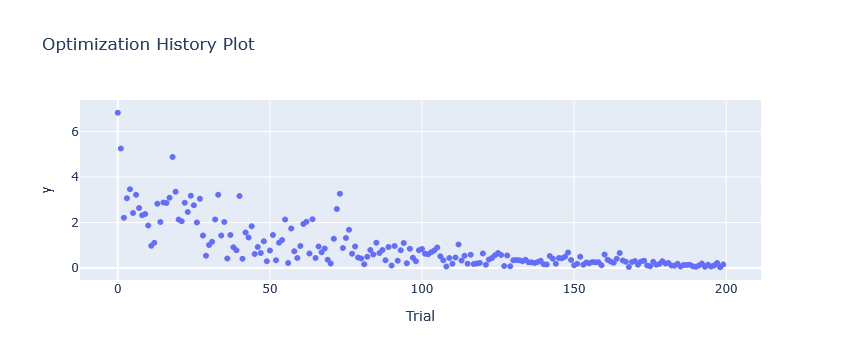

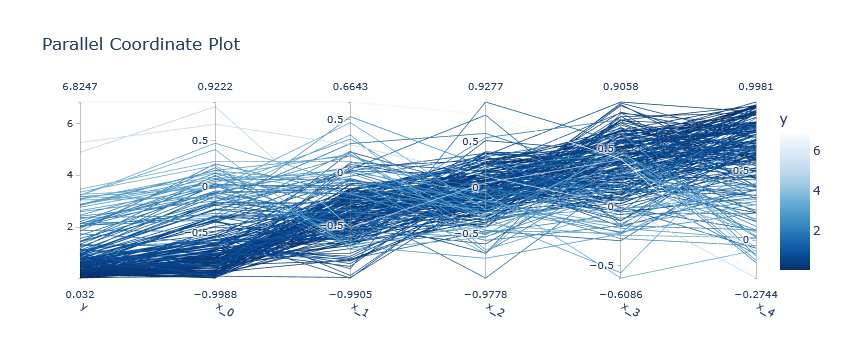

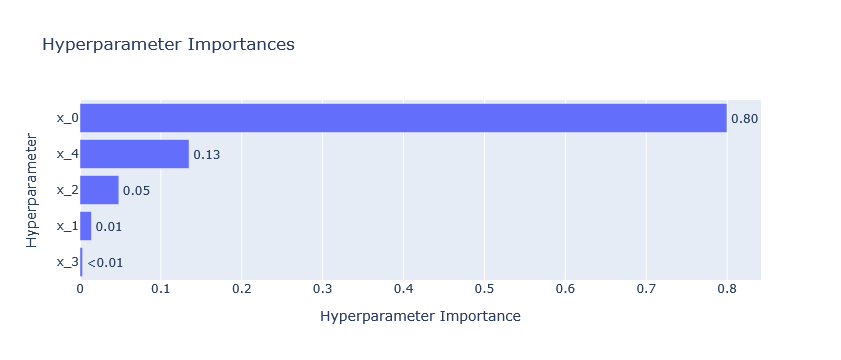

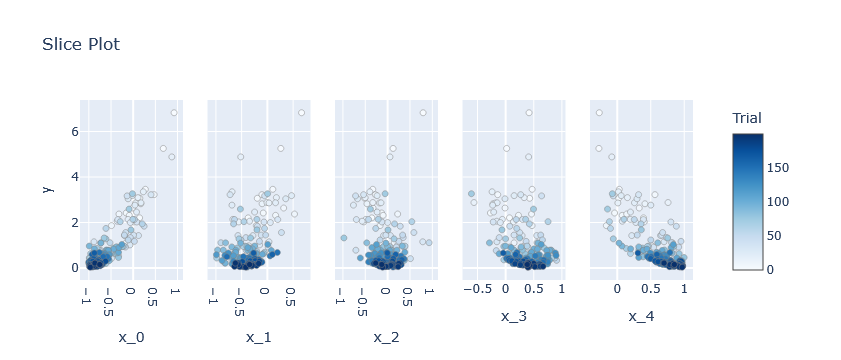

In [38]:
def objective(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    beta_star = np.array(list(parameters.values()))
    simulated_data = g(beta_star) + observation_noise

    metric = MeanSquaredError()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

specification = OptimisationMethodModel(
	experiment_name="optuna_optimisation",
	parameter_spec=parameter_spec,
	observed_data=observed_df.y.values,
	method="cmaes",
	directions=["minimize"],
	output_labels=["y"],
	n_iterations=200,
    n_jobs=-1,
    verbose=False
)

calibrator = OptimisationMethod(
	calibration_func=objective, specification=specification, engine="optuna"
)
calibrator.specify().execute().analyze()

In [47]:
optimisation_df = pd.DataFrame({
    "beta_name": [f"x_{i}" for i in range(p)],
    "beta_estimate": [ 
        model.estimate
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "beta_value": beta_true
})
optimisation_df

,beta_name,beta_estimate,beta_value
0,x_0,-0.926907,-1.0
1,x_1,-0.513389,-0.5
2,x_2,-0.014776,0.0
3,x_3,0.493632,0.5
4,x_4,0.913005,1.0


According to the fANOVA hyperparameter importances, the most influential parameters of the model are x_0 and x_4. This supports the results of the Sobol sensitivity analysis.

We also see that there are diminishing returns in the objective function results after 100 optimisation trials.

# Bayesian Calibration

In some cases, we will want to return a full probability distribution of plausible parameter estimates, rather than a single point estimate. Bayesian calibration is one such approach for yielding these probabilistic estimates. Bayesian calibration is also particularly useful when working with complex, stochastic simulation models where equifinality may be present.

In [40]:
from calisim.abc import (
	ApproximateBayesianComputationMethod,
	ApproximateBayesianComputationMethodModel,
)

We first construct the parameter specification for Bayesian calibration. As we are going Bayesian, we can specify more complex probability distributions than the uniform distribution. In this example, we will use truncated normal distributions for our parameters.

We specify both the location and scale (mean=0 and standard deviation=0.33), alongside the lower and upper bounds (lb = -1 and ub = 1) for the truncated normal distributions.

In [41]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="x_0",
			distribution_name="truncnorm",
			distribution_args=[-1 / 0.33, 1 / 0.33],
            distribution_kwargs=dict(loc=0, scale=0.33),
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_1",
			distribution_name="truncnorm",
			distribution_args=[-1 / 0.33, 1 / 0.33],
            distribution_kwargs=dict(loc=0, scale=0.33),
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_2",
			distribution_name="truncnorm",
			distribution_args=[-1 / 0.33, 1 / 0.33],
            distribution_kwargs=dict(loc=0, scale=0.33),
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_3",
			distribution_name="truncnorm",
			distribution_args=[-1 / 0.33, 1 / 0.33],
            distribution_kwargs=dict(loc=0, scale=0.33),
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_4",
			distribution_name="truncnorm",
			distribution_args=[-1 / 0.33, 1 / 0.33],
            distribution_kwargs=dict(loc=0, scale=0.33),
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

We will use Approximate Bayesian Computation (ABC) Sequential Monte Carlo to calibrate the model. ABC aims to minimise the discrepancy between observed and simulated data up to a tolerance threshold (epsilon). Larger values of epsilon will result in faster model calibration but less precise estimates. Smaller values of epsilon will result in slower model calibration but more precise estimates.

Moreover, rather than using the mean squared error, ABC instead requires the use of proper distance metrics. Hence, we will use the L2 norm to quantify the discrepancy between the observed and simulated data.

ABC.History INFO: Start <ABCSMC id=1, start_time=2025-10-02 12:16:09>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.73064872e+01.
ABC INFO: Accepted: 20 / 38 = 5.2632e-01, ESS: 2.0000e+01.
ABC.Adaptation INFO: Change nr particles 20 -> 10
ABC INFO: t: 1, eps: 1.47382131e+01.
ABC INFO: Accepted: 10 / 28 = 3.5714e-01, ESS: 6.9424e+00.
ABC.Adaptation INFO: Change nr particles 10 -> 10
ABC INFO: t: 2, eps: 1.25562640e+01.
ABC INFO: Accepted: 10 / 19 = 5.2632e-01, ESS: 3.5176e+00.
ABC.Adaptation INFO: Change nr particles 10 -> 10
ABC INFO: t: 3, eps: 1.22193934e+01.
ABC INFO: Accepted: 10 / 18 = 5.5556e-01, ESS: 3.7153e+00.
ABC.Adaptation INFO: Change nr particles 10 -> 10
ABC INFO: t: 4, eps: 1.01219124e+01.
ABC INFO: Accepted: 10 / 21 = 4.7619e-01, ESS: 4.5715e+00.
ABC.Adaptation INFO: Change nr particles 10 -> 10
ABC INFO: t: 5, eps: 8.84502151e+00.
ABC INFO: Accepted: 10 / 27 = 3.7037e-01, ESS: 2.5888e+00.
ABC.Adaptation INFO: Change nr particles 10 -> 10
ABC INFO: t: 6, e

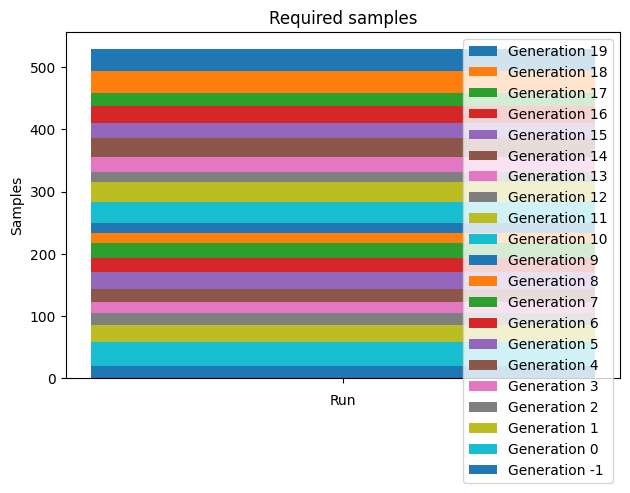

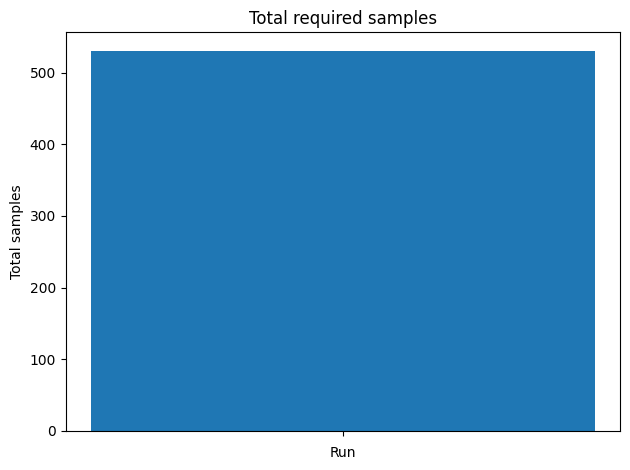

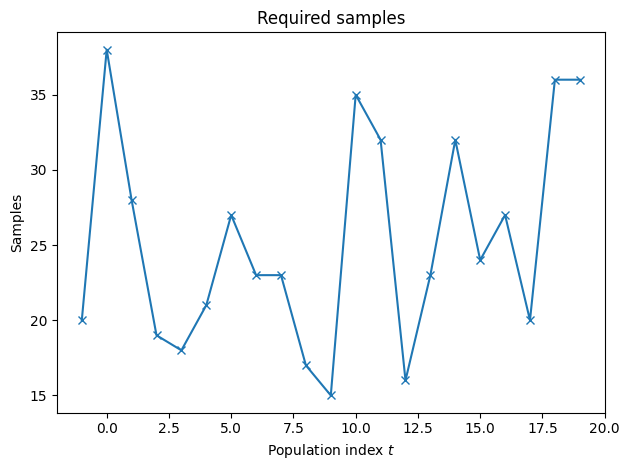

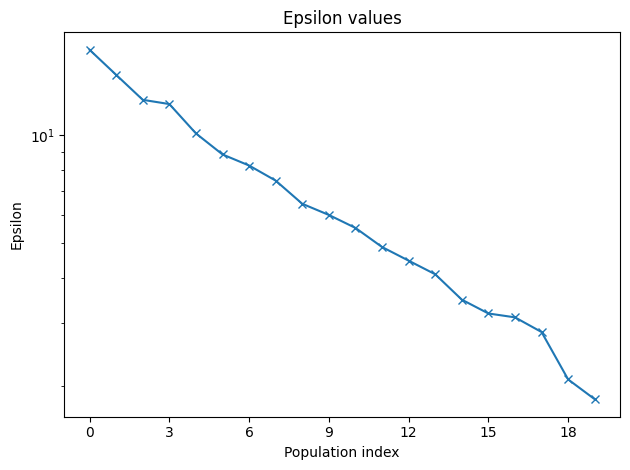

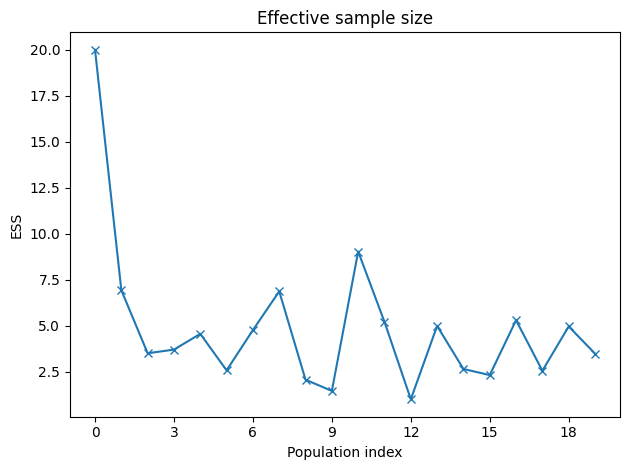

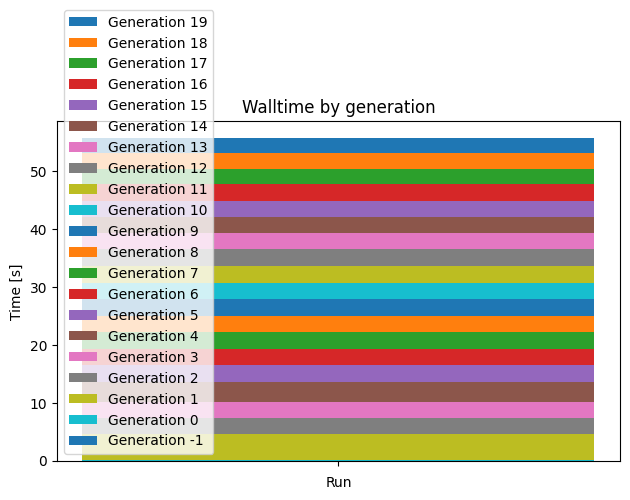

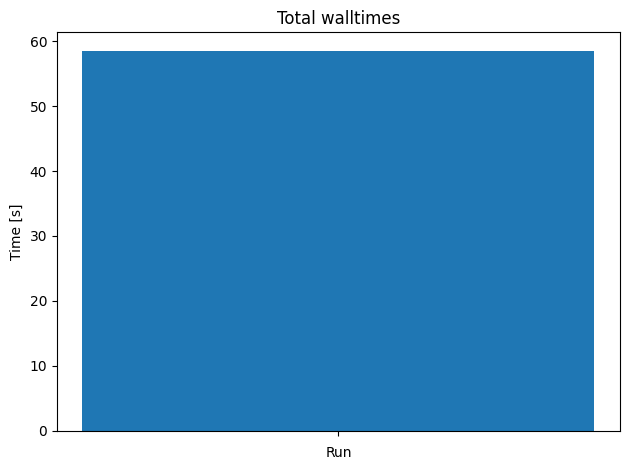

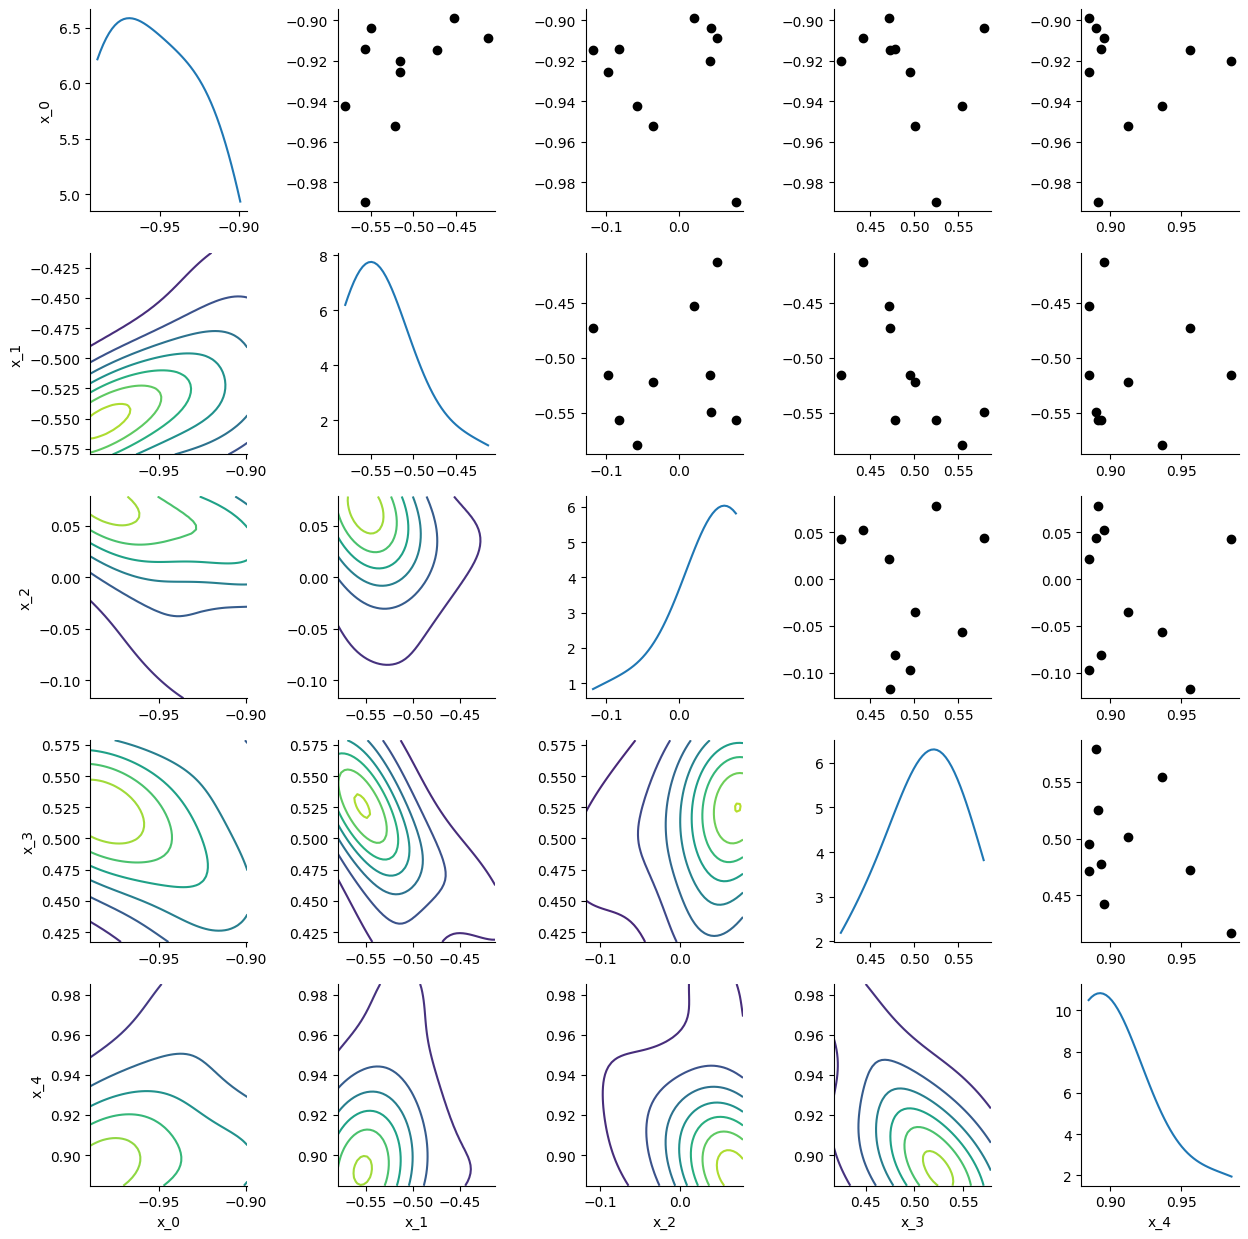

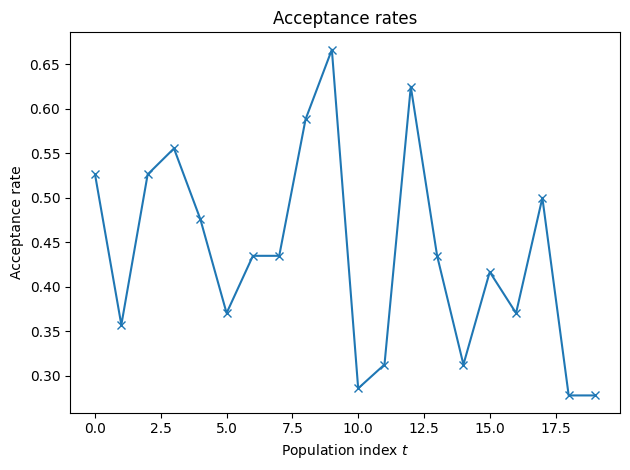

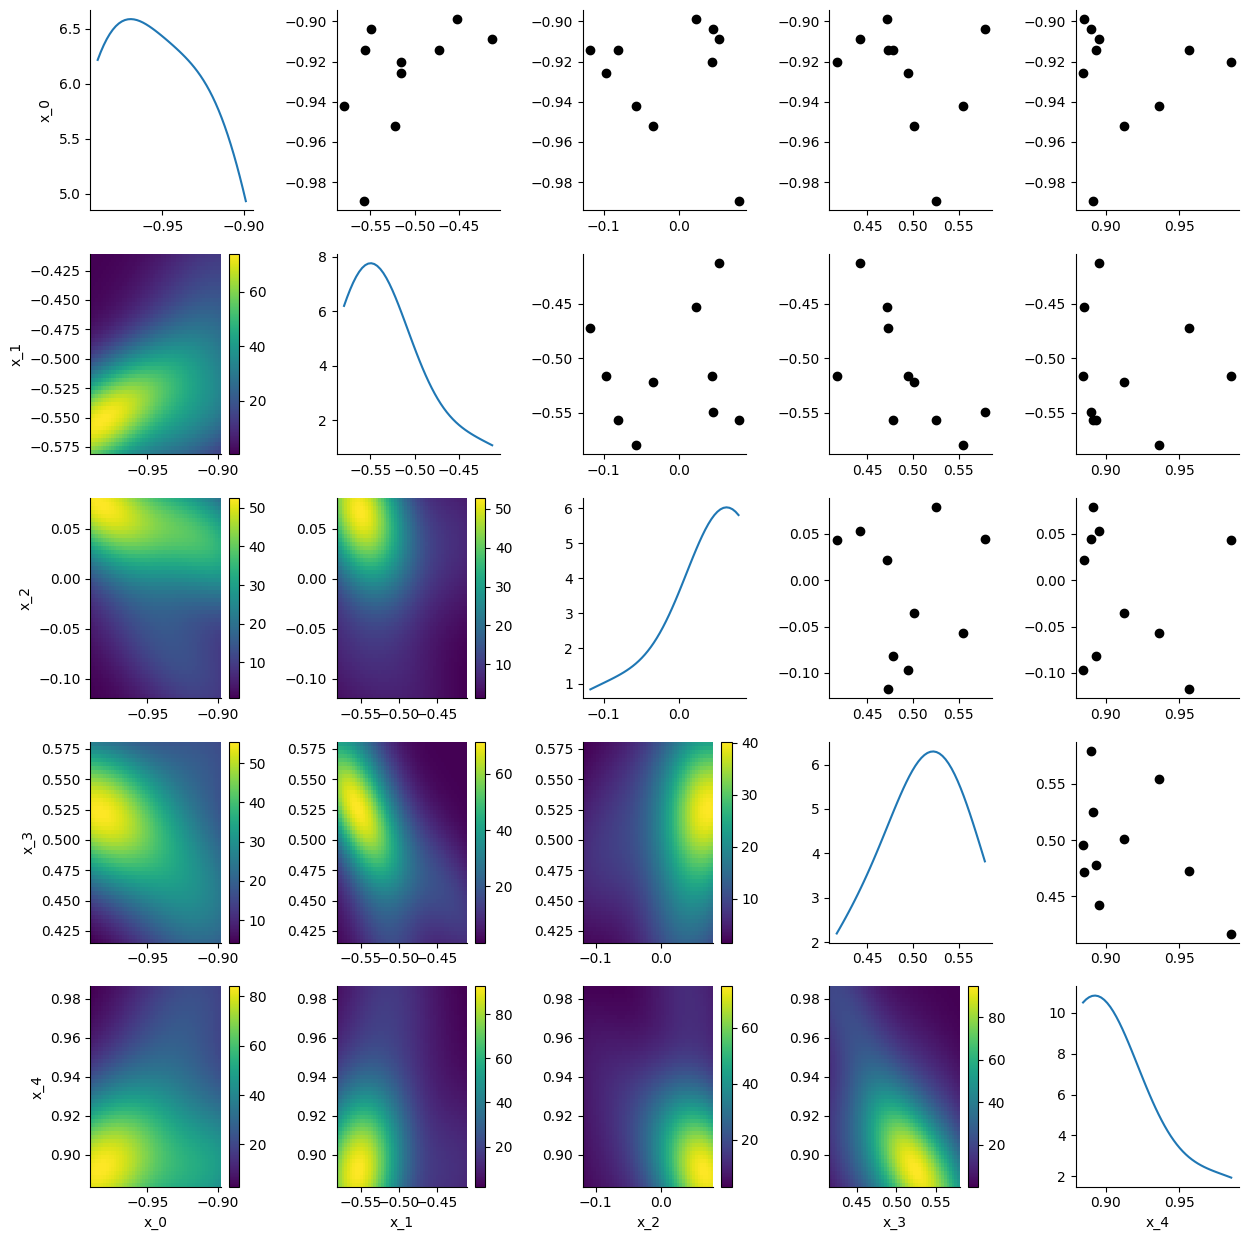

In [42]:
def abc_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    beta_star = np.array(list(parameters.values()))
    simulated_data = g(beta_star) + observation_noise

    metric = L2Norm()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

specification = ApproximateBayesianComputationMethodModel(
	experiment_name="pyabc_approximate_bayesian_computation",
	parameter_spec=parameter_spec,
	observed_data=observed_df.y.values,
	n_init=20,
	walltime=5,  # minutes
	epsilon=1,
	output_labels=["y"],
	n_bootstrap=20,
	min_population_size=20,
	verbose=True,
	batched=False,
    random_seed=100,
	method_kwargs=dict(
		max_total_nr_simulations=700, max_nr_populations=20, min_acceptance_rate=0.0
	),
)

calibrator = ApproximateBayesianComputationMethod(
	calibration_func=abc_func, specification=specification, engine="pyabc"
)

calibrator.specify().execute().analyze()

In [45]:
abc_df = pd.DataFrame({
    "beta_name": [f"x_{i}" for i in range(p)],
    "beta_estimate": [ 
        model.estimate
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "beta_uncertainty": [ 
        model.uncertainty
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "beta_value": beta_true
})
abc_df

,beta_name,beta_estimate,beta_uncertainty,beta_value
0,x_0,-0.926907,0.027457,-1.0
1,x_1,-0.513389,0.052699,-0.5
2,x_2,-0.014776,0.070997,0.0
3,x_3,0.493632,0.049028,0.5
4,x_4,0.913005,0.034808,1.0


We can see that unlike the black-box optimisation example above, Bayesian calibration provides a measure of uncertainty around the point estimates (the posterior mean and standard deviation).

# Plots

Let's take the point estimates from the ABC calibrator, run the forward model using those estimates, then compare them with our observed data.

<Axes: xlabel='observed', ylabel='simulated'>

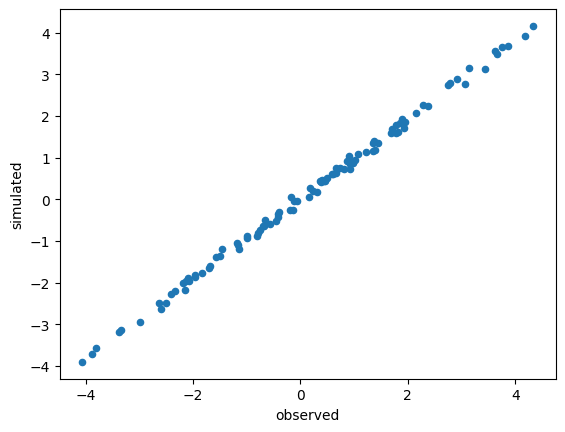

In [46]:
pd.DataFrame({
    "observed": observed_df.y.values,
    "simulated": g(abc_df.beta_estimate.values) + observation_noise
}).plot.scatter("observed", "simulated")